In [22]:
transform_cifar = T.Compose([
    T.ToTensor(),
    T.Normalize([.491, 0.482, 0.447],[0.247, 0.243, 0.261])
])

cifar10_train = datasets.CIFAR10(
    DATA_PATH,
    train = True,
    download=True,
    transform=transform_cifar
)

train_loader = DataLoader(
    cifar10_train,
    batch_size=MINIBATCH_SIZE,
    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN))  #Elementos Aletorios
)

cifar10_val = datasets.CIFAR10(
    DATA_PATH, 
    train=False, 
    download=True, 
    transform=transform_cifar
)

val_loader = DataLoader(
    cifar10_val,
    batch_size=MINIBATCH_SIZE, 
    sampler=sampler.SubsetRandomSampler(range(NUM_VAL))
)

cifar10_test = datasets.CIFAR10(
    DATA_PATH, 
    train = False,
    download = True,
    transform = transform_cifar
)

test_loader = DataLoader(
    cifar10_test,
    batch_size = MINIBATCH_SIZE,
    sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(cifar10_test)))
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [25]:
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: /home/matasietephi/Documentos/jupyterNOTEBOOK/cifar-10-batches-py
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
                         )
    Target Transforms (if any): None

In [26]:
test_loader.dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: /home/matasietephi/Documentos/jupyterNOTEBOOK/cifar-10-batches-py
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
                         )
    Target Transforms (if any): None

In [27]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


La muestra representa un:frog


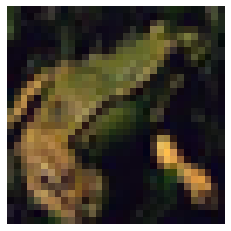

In [29]:
classes = test_loader.dataset.classes

def plot_figure(image):
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()
    
rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La muestra representa un:{classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() - image.min())
plot_figure(image)

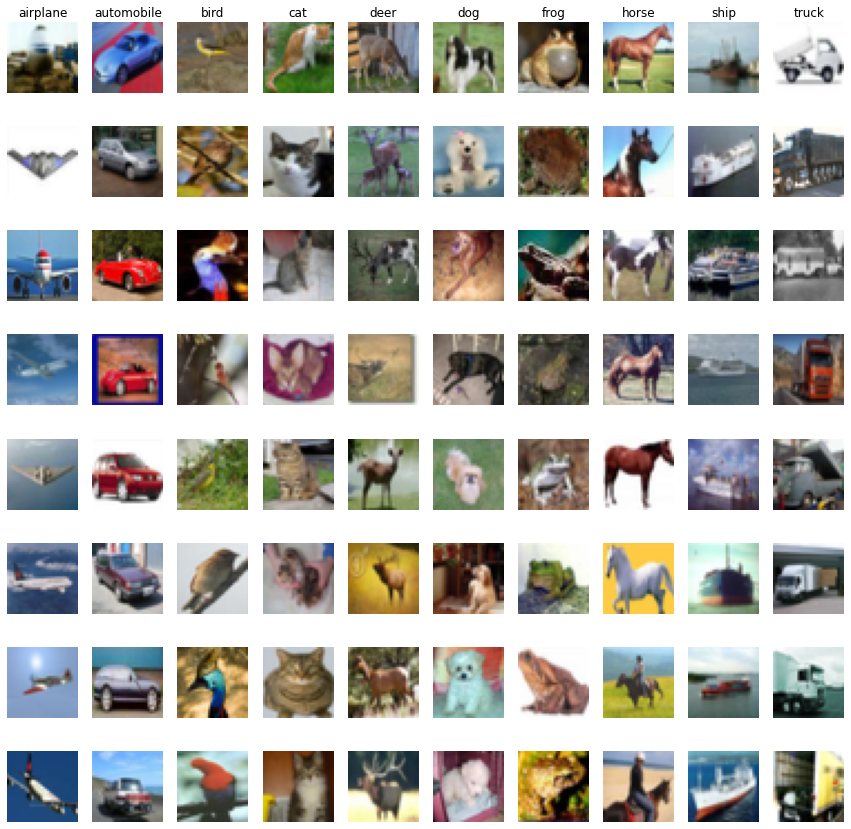

In [34]:
def plot_cifar10_grid():
    classes = test_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace= False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(test_loader.dataset.data[idx])
            plt.axis('off')
            
            if i == 0: plt.title(sample)
    plt.show()
    
plot_cifar10_grid()

In [36]:
for i, (x,y) in enumerate(test_loader):
    print(i, x.shape, y.shape)

0 torch.Size([64, 3, 32, 32]) torch.Size([64])
1 torch.Size([64, 3, 32, 32]) torch.Size([64])
2 torch.Size([64, 3, 32, 32]) torch.Size([64])
3 torch.Size([64, 3, 32, 32]) torch.Size([64])
4 torch.Size([64, 3, 32, 32]) torch.Size([64])
5 torch.Size([64, 3, 32, 32]) torch.Size([64])
6 torch.Size([64, 3, 32, 32]) torch.Size([64])
7 torch.Size([64, 3, 32, 32]) torch.Size([64])
8 torch.Size([64, 3, 32, 32]) torch.Size([64])
9 torch.Size([64, 3, 32, 32]) torch.Size([64])
10 torch.Size([64, 3, 32, 32]) torch.Size([64])
11 torch.Size([64, 3, 32, 32]) torch.Size([64])
12 torch.Size([64, 3, 32, 32]) torch.Size([64])
13 torch.Size([64, 3, 32, 32]) torch.Size([64])
14 torch.Size([64, 3, 32, 32]) torch.Size([64])
15 torch.Size([64, 3, 32, 32]) torch.Size([64])
16 torch.Size([64, 3, 32, 32]) torch.Size([64])
17 torch.Size([64, 3, 32, 32]) torch.Size([64])
18 torch.Size([64, 3, 32, 32]) torch.Size([64])
19 torch.Size([64, 3, 32, 32]) torch.Size([64])
20 torch.Size([64, 3, 32, 32]) torch.Size([64])
21

In [46]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for xi, yi in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi)           # Se obtiene los scores 
            _, pred = scores.max(dim=1) #se obtiene el máximo score, regresa el índice del max score
            num_correct += (pred == yi).sum() # Coloca 1 y 0 en las clases que corresponde, sumando, acumulando
            num_total += pred.size(0)         # Acumula el total de objetos correctos 
        return float(num_correct)/num_total   # Promedio de los resultados correctos 

In [47]:
def train(model, optimiser, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi,yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            cost = F.cross_entropy(input=scores, target=yi)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
        acc = accuracy(model, val_loader)
        print(f'Época:{epoch}, Costo:{cost.item()}, Accuracy:{acc},')
        

$\Huge{Modelo \ Lineal}$

In [48]:
hidden1 = 256
hidden = 256
lr = 0.0001
epochs = 10

model1 = nn.Sequential(nn.Flatten(),
                       nn.Linear(in_features=32*32*3, out_features=hidden1),
                       nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden),
                       nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10)
)
optimiser = torch.optim.Adam(model1.parameters(), lr=lr)

train(model1, optimiser, epochs)

Época:0, Costo:1.3992642164230347, Accuracy:0.4736,
Época:1, Costo:1.2262789011001587, Accuracy:0.4986,
Época:2, Costo:1.2399086952209473, Accuracy:0.5158,
Época:3, Costo:1.2769566774368286, Accuracy:0.5266,
Época:4, Costo:1.083403468132019, Accuracy:0.5312,
Época:5, Costo:1.2159472703933716, Accuracy:0.5324,
Época:6, Costo:0.9851889610290527, Accuracy:0.5448,
Época:7, Costo:0.7985164523124695, Accuracy:0.5422,
Época:8, Costo:1.0327080488204956, Accuracy:0.5446,
Época:9, Costo:1.072005271911621, Accuracy:0.5444,


$\huge{Modelo \ CNN}$

In [52]:
CHANNEL1 = 16
CHANNEL2 = 32
epochs = 10
lr = 0.0001

modelCNN1 =  nn.Sequential(
    nn.Conv2d(in_channels = 3, out_channels=CHANNEL1, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=CHANNEL1, out_channels=CHANNEL2, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(in_features=16*16*CHANNEL2, out_features=10)
)
optimizer = torch.optim.Adam(modelCNN1.parameters(), lr)

In [53]:
train(modelCNN1, optimizer, epochs)

Época:0, Costo:1.5731128454208374, Accuracy:0.4736,
Época:1, Costo:1.2586621046066284, Accuracy:0.5244,
Época:2, Costo:1.2003231048583984, Accuracy:0.552,
Época:3, Costo:1.1721906661987305, Accuracy:0.5692,
Época:4, Costo:1.2500197887420654, Accuracy:0.5888,
Época:5, Costo:1.1836929321289062, Accuracy:0.6024,
Época:6, Costo:1.0186080932617188, Accuracy:0.6088,
Época:7, Costo:0.8544989824295044, Accuracy:0.618,
Época:8, Costo:0.8630064129829407, Accuracy:0.6214,
Época:9, Costo:0.9099276065826416, Accuracy:0.6274,
